handle imports, nameing models in gan, calc d reseptive field,renaming vars, commenting

# Imports

In [1]:
import os
import logging
import cv2
import glob
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from PIL import Image
from numpy import ones
from numpy import zeros
from numpy.random import randint
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal
from keras.models import Model,Input
from keras.layers import Conv2D,MaxPool2D,Convolution2DTranspose,LeakyReLU,Dropout,BatchNormalization,Flatten,Dense,Reshape
from keras import backend as K
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint


# example of pix2pix gan for satellite to map image-to-image translation

from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/Computer Vision Course/Final Project")

Mounted at /content/drive


In [3]:
!nvidia-smi

Sun Mar 20 15:59:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
print("Num GPUs Available ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available  1


# Experiment 4

## Hyper-Parameters

In [5]:
X_path = "Data/cat_missing"
Y_path = "Data/cats"
models_path = "Models"
experiance_name = "experiment_4"

EPOCHS = 20
BATCH_SIZE = 1
IMG_DIM = 128

G_LR = 0.0002
D_LR =0.0002

target_size = (IMG_DIM,IMG_DIM)
input_shape = (IMG_DIM,IMG_DIM,3)

data_trans = ImageDataGenerator(rotation_range=15,height_shift_range=0.1,horizontal_flip=True, zoom_range=0.10)

## Loading Data

In [6]:
def normlize(img):
  return (img / 127.5) - 1

def unnormlize(img):
  return ((img + 1) * 127.5).astype("int16")

def load_image(img_name,folder_path,img_dim = None,normlize = False):
    img_path = folder_path + "/" + img_name
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img_dim:
      img = cv2.resize(img, dsize=(img_dim, img_dim), interpolation=cv2.INTER_CUBIC)
    img = np.array(img)
    if normlize:
      img = (img / 127.5) - 1
    return img.astype("float32")

In [7]:
def load_data_as_np(X_path,Y_path,img_dim=None,normlize=True):
  training_binary_path = f"Data/dataset_{img_dim}.npy"

  if not os.path.isfile(training_binary_path):
    dataset = []
    for count, image in enumerate(glob.glob(f'{X_path}/*')):
      x_img = load_image(image.split(os.path.sep)[-1],X_path,img_dim,normlize = normlize)
      y_img = load_image(image.split(os.path.sep)[-1],Y_path,img_dim,normlize = normlize)
      dataset.append(np.array([x_img,y_img]))

      if count != 0 and count % 100 == 0:
        print("Loaded "+str(count)+" Images...")

    dataset = np.array(dataset)
    print(f"Saving dataset as {training_binary_path}")
    np.save(training_binary_path,dataset)

  else:
    print(f"Loading existing dataset from '{training_binary_path}'...")
    dataset = np.load(training_binary_path)
    print(f"Finished loading dataset shaped {dataset.shape}.")
  
  return dataset.astype("float32")

In [8]:
def fill_image(missing_img, new_img):
  # assume is unnormlized
  missing_img = missing_img.copy().astype("int16")
  missing_block = np.array([256,256,256])
  missing_block2 = np.array([253,253,253])
  for i in range(IMG_DIM):
    for j in range(IMG_DIM):
      p1 = missing_block2 <= missing_img[i][j]
      p2 = missing_img[i][j] <= missing_block
      p = np.logical_and(p1, p2)
      if p.all():
        missing_img[i][j] = new_img[i][j]
  return missing_img

In [9]:
def plot_image(img,unnormlize = False):
  if unnormlize:
    img = img.copy()
    img = np.array(img)
    img = (img + 1)*127.5
    img = img.astype("int32")
  plt.figure()
  plt.imshow(img)
  plt.axis('off')
  plt.show()

def plotXY(x,y,titels = ['Missing Image','Real Image']):  
  # assume is normlized
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.title(titels[0])
  x = (x + 1)*127.5
  x = x.astype("int32")
  plt.axis('off')
  plt.imshow(x)
  plt.subplot(1, 2, 2)
  plt.title(titels[1])
  y = (y + 1)*127.5
  y = y.astype("int32")
  plt.imshow(y)
  plt.axis('off')

  plt.show()

In [10]:
def augment(img1, img2, transformer):
  if transformer is not None:
    transform = transformer.get_random_transform(target_size)
    if len(img1.shape) == 4:
      if img1 is not None:
        img1[0] =  transformer.apply_transform(img1[0],transform)
      if img2 is not None:
        img2[0] =  transformer.apply_transform(img2[0],transform)
    else:
      if img1 is not None:
        img1 =  transformer.apply_transform(img1,transform)
      if img2 is not None:
        img2 =  transformer.apply_transform(img2,transform)
  return img1, img2

In [11]:
train_dataset = load_data_as_np(X_path,Y_path,IMG_DIM)

Loading existing dataset from 'Data/dataset_128.npy'...
Finished loading dataset shaped (5652, 2, 128, 128, 3).


In [12]:
train_dataset, test_dataset = train_test_split(train_dataset, test_size=0.20, random_state=42)

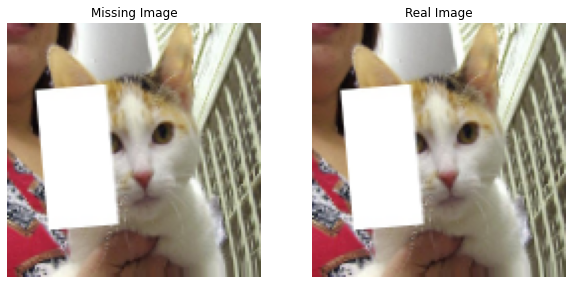

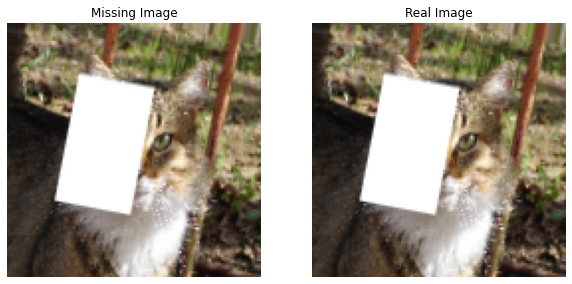

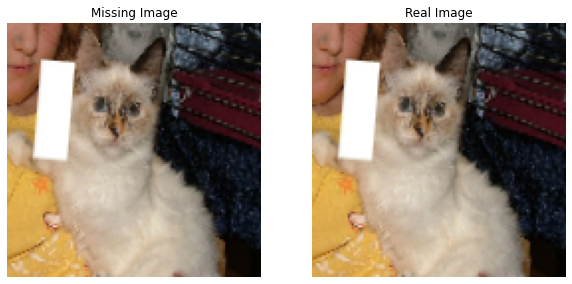

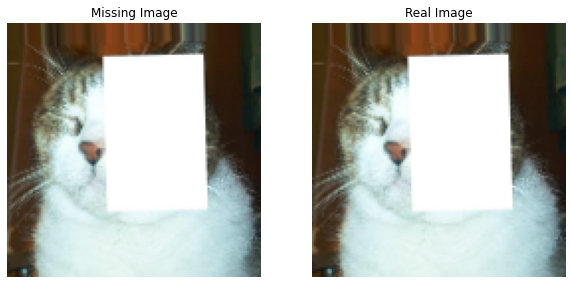

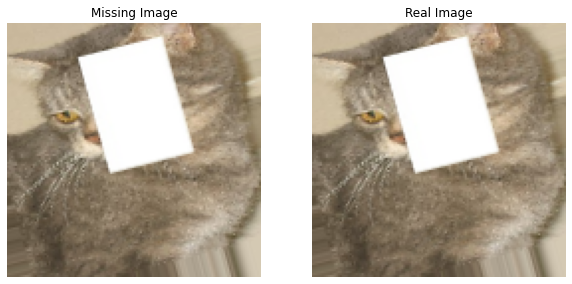

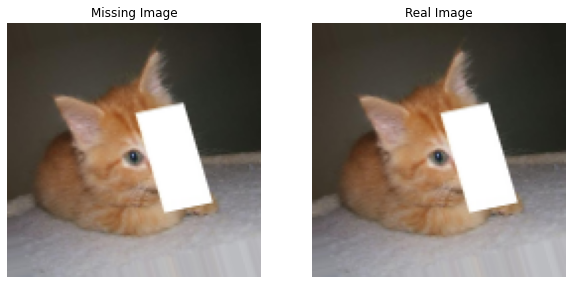

In [13]:
train_dataset = shuffle(train_dataset)

for i,batch in enumerate(train_dataset):
  x , y = augment(batch[0],batch[0],data_trans)
  plotXY(x,y)
  if i == 5:
    break

## Generator

In [14]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	if not skip_in == None:
		g = Concatenate()([g, skip_in])
	# relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e6)
	b = LeakyReLU(alpha=0.2)(b)
	# decoder model
	d1 = decoder_block(b, e6, 512, dropout=False)
	d2 = decoder_block(d1, e5, 512, dropout=False)
	d3 = decoder_block(d2, e4, 512, dropout=False)
	d4 = decoder_block(d3, e3, 256, dropout=False)
	d5 = decoder_block(d4, e2, 128, dropout=False)
	d6 = decoder_block(d5, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [15]:
g_model = define_generator(input_shape)
g_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   3136        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 128)  131200      ['leaky_re_lu[0][0]']        

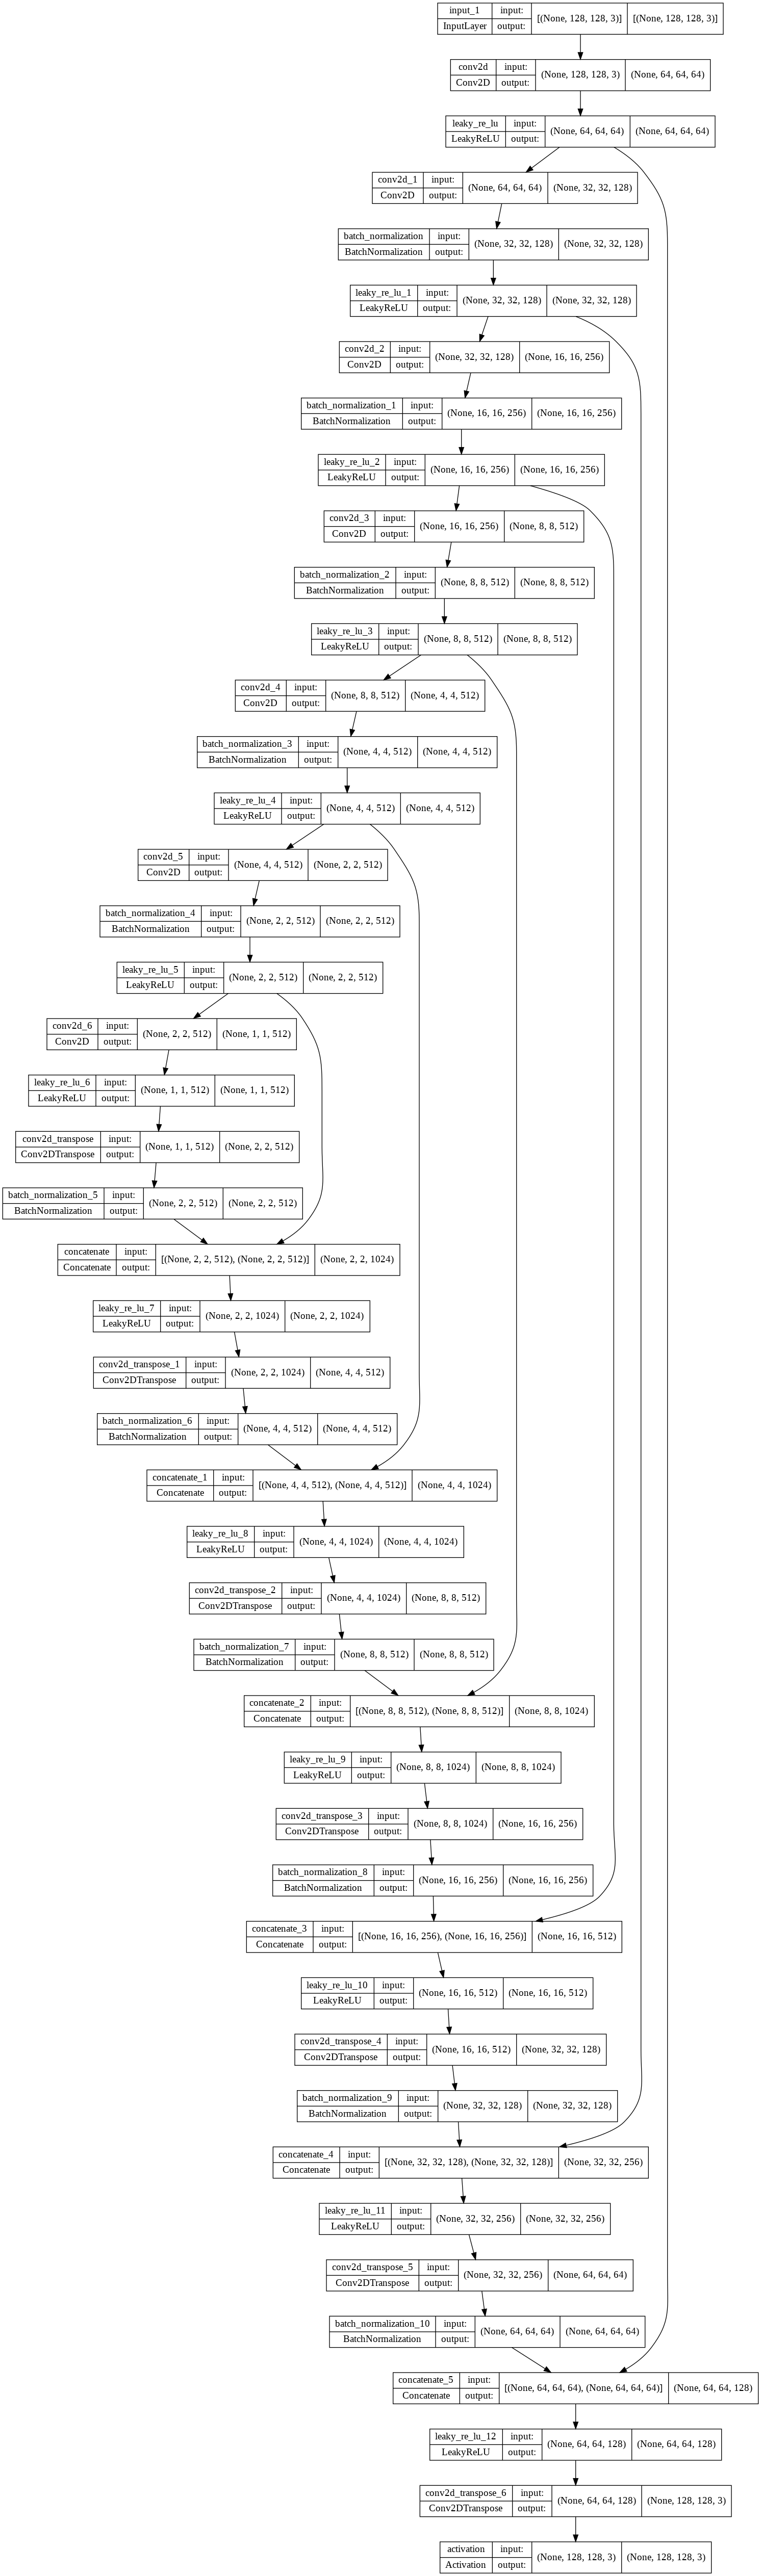

In [16]:
plot_model(g_model, show_shapes=True, show_layer_names=True)

## Discriminator

In [17]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), strides=(4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(learning_rate=D_LR, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [18]:
d_model = define_discriminator(input_shape)
d_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_6 (Concatenate)    (None, 128, 128, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

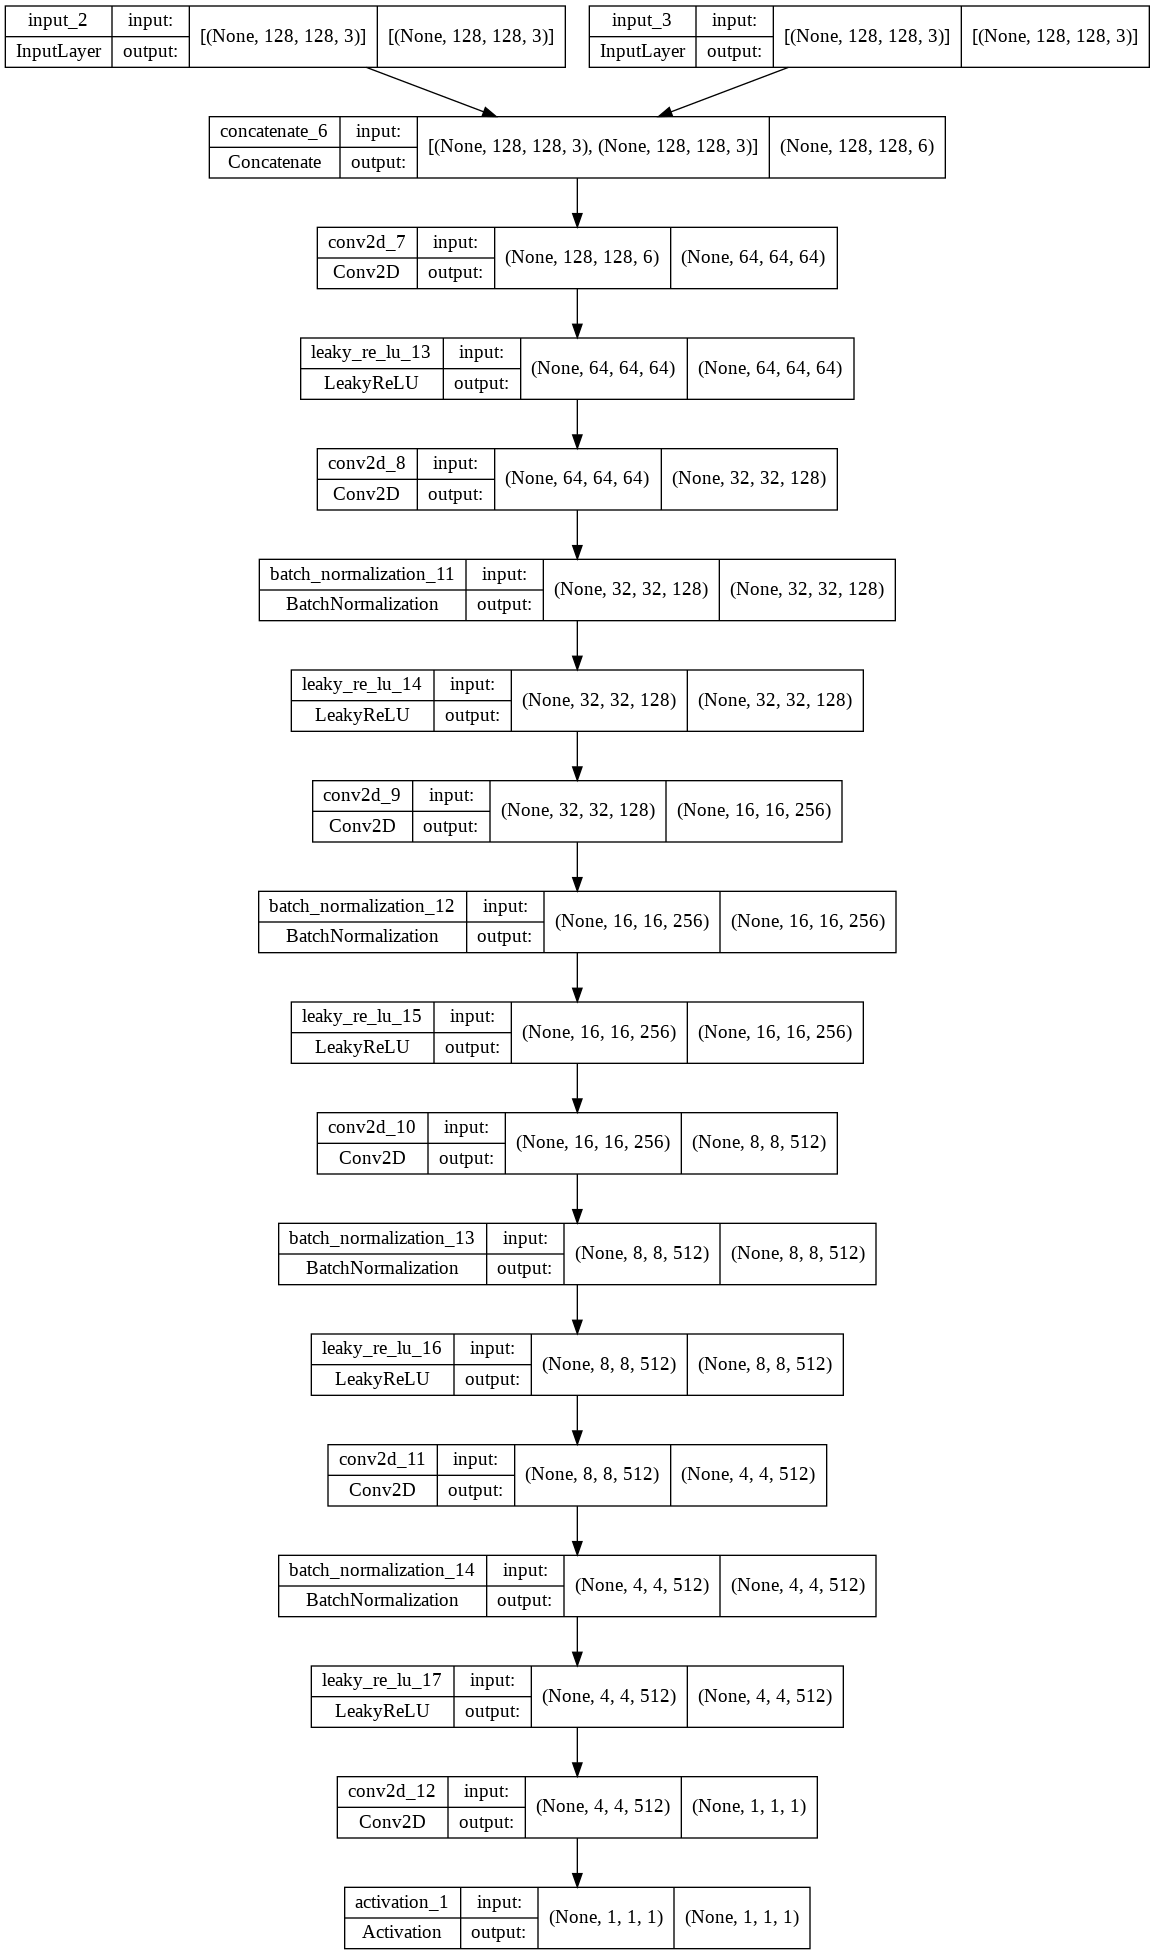

In [19]:
plot_model(d_model, show_shapes=True, show_layer_names=True)

## The GAN Model

In [20]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=G_LR, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[10,90])
	return model

In [21]:
gan_model = define_gan(g_model, d_model, input_shape)

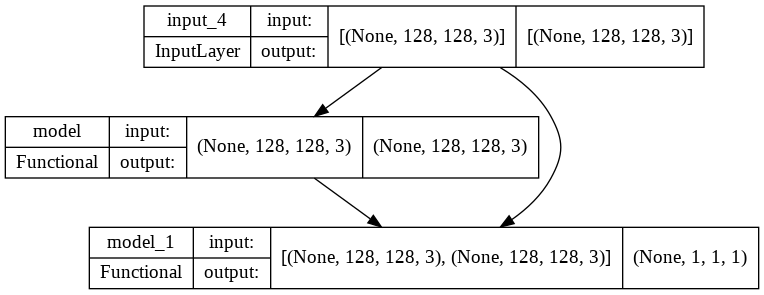

In [22]:
plot_model(gan_model, show_shapes=True, show_layer_names=True)

## Training

In [23]:
def plot_prediction(missing_img, real_img, generated_img):
  plt.figure(figsize=(10, 10))

  plt.subplot(1, 4, 1)
  plt.title('Missing Image')
  missing_img = missing_img.copy()
  missing_img = (missing_img + 1)*127.5
  missing_img = missing_img.astype("int32")
  plt.axis('off')
  plt.imshow(missing_img)

  plt.subplot(1, 4, 2)
  plt.title('Real Image')
  real_img = real_img.copy()
  real_img = (real_img + 1)*127.5
  real_img = real_img.astype("int32")
  plt.imshow(real_img)
  plt.axis('off')

  plt.subplot(1, 4, 3)
  plt.title('Full Generated Image')
  generated_img = generated_img.copy()
  generated_img = (generated_img + 1)*127.5
  generated_img = generated_img.astype("int32")
  plt.axis('off')
  plt.imshow(generated_img)

  plt.subplot(1, 4, 4)
  plt.title('Generated Image')
  generated_img = fill_image(missing_img,generated_img)
  plt.imshow(generated_img)
  plt.axis('off')

  plt.show()

In [24]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, x_input, patch_shape):
		# generate fake instance
		X = g_model.predict(x_input)
		# create 'fake' class labels (0)
		y = zeros((len(X), patch_shape, patch_shape, 1))
		return X, y

In [25]:
# generate samples and save as a plot and save the model
def summarize_performance(g_model, dataset, n_samples=5,save = False):
		index = random.randrange(len(dataset) - n_samples)
		for i in range(index,index + n_samples):
			
				# select a sample of input images
				X_real_input = dataset[i,0]
				X_real_target =  dataset[i,1]
				# generate a batch of fake samples
				X_fake_output, _ = generate_fake_samples(g_model, X_real_input.reshape(1,IMG_DIM,IMG_DIM,3), 1)
				# plot real source images
				plot_prediction(X_real_input,X_real_target,X_fake_output[0])
		if save:
				print("saving models")
				# save the generator model
				g_model.save(f'{models_path}/{experiance_name}_g.h5')
				# save the discriminator model
				d_model.save(f'{models_path}/{experiance_name}_d.h5')

In [26]:
# train pix2pix model
def train_gan(d_model, g_model, gan_model, dataset, test_dataset, epochs ,transformer, n_batch=1):
    # vars to track history
    history_g_loss = []
    history_d_loss = []

    # determine the output square shape of the discriminator
    d_patch_dim = d_model.output_shape[1]
    # calculate the number of batches per training epoch
    data_len = len(dataset) 

    time = timer()

    # give dataset a batch dimantion
    dataset = dataset.reshape((len(dataset), 2, 1, IMG_DIM, IMG_DIM, 3))

    for epoch in range(epochs):
        # vars to track loss in epoch
        g_total_loss = 0
        d_loss_real_sum = 0
        d_loss_fake_sum = 0
        
        i = 0
        for batch in dataset:
            # get inputs for discriminator
            # select a batch of real samples
            X_real_input, X_real_target = augment(batch[0].copy(),batch[1].copy(),transformer)
            y_real  = ones((1, d_patch_dim, d_patch_dim, 1))

            # generate a batch of fake samples
            X_fake_output, y_fake = generate_fake_samples(g_model, X_real_input, d_patch_dim)

            # train discriminator
            # update discriminator for real samples
            d_loss_r = d_model.train_on_batch([X_real_input, X_real_target], y_real)
            # update discriminator for generated samples
            d_loss_f = d_model.train_on_batch([X_real_input, X_real_target], y_fake)

            # train generator
            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_real_input, [y_real, X_real_target])

            # track vars
            g_total_loss += g_loss
            d_loss_real_sum += d_loss_r
            d_loss_fake_sum += d_loss_f

            # print
            i += 1
            print("\r"+"Epoch number: {}/{}, Batch: {}/{}, G Loss:{:0.4f}, D Loss Real:{:0.4f}, D Loss Fake:{:0.4f}".format(
                epoch + 1,epochs,i,data_len,g_total_loss / i,d_loss_real_sum / i,d_loss_fake_sum / i), end="")
            
        # epoch ended
        # vars to summorize epoch for printing and history
        g_epoch_total_loss = g_total_loss / data_len
        d_epoch_real_loss = d_loss_real_sum / data_len
        d_epoch_fake_loss = d_loss_fake_sum / data_len
        d_epoch_loss = (d_epoch_real_loss + d_epoch_fake_loss) / 2 

        # appending history
        history_g_loss.append(g_epoch_total_loss)
        history_d_loss.append(d_epoch_loss)

        # printing
        print("\n\nFinished Epoch: {},\nGenerator Loss:{:0.4f}, Discriminator Total Loss:{:0.2f}, \nDiscriminator Real Loss:{:0.4f}, Discriminator Fake Loss:{:0.2f}".format(
          epoch+1,g_epoch_total_loss,d_epoch_loss,d_epoch_real_loss,d_epoch_fake_loss))

        # shuffle data
        dataset = shuffle(dataset)
        # save if epoch > 10
        save = epoch > 10
        # summarize performance on test set
        summarize_performance(g_model, test_dataset, n_samples=5,save = save)

    # training end
    total_time = round((timer() - time)/60)
    print(f"Finished training after {total_time} minutes.")

    history = {}

    history['g_loss'] = history_g_loss
    history['d_loss'] = history_d_loss
    return history

In [ ]:
history = train_gan(d_model, g_model, gan_model, train_dataset,test_dataset,EPOCHS,data_trans)

Epoch number: 1/20, Batch: 3178/4521, G Loss:18.0881, D Loss Real:0.4894, D Loss Fake:0.5302

## Evaluate

In [ ]:
def plot_loss(history):
  plt.plot(history['g_loss'])
  plt.plot(history['d_loss'])
  plt.title('gan loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['generator', 'discriminator'], loc='upper left')
  plt.show()

In [ ]:
plot_loss(history)

In [ ]:
summarize_performance(g_model, test_dataset,n_samples=20,save = False)

In [ ]:
g_model.save(f'{models_path}/{experiance_name}_g.h5')
d_model.save(f'{models_path}/{experiance_name}_d.h5')